In [1]:
#Importing libraraies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/simple-loan-classification-dataset/loan.csv


In [2]:
loan = pd.read_csv('/kaggle/input/simple-loan-classification-dataset/loan.csv')

In [3]:
loan.head()

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved


In this dataset, `loan_status` is the target variable. We will use the Decision Tree Classification approach to predict whether a given person is eligible for a loan by learning decision rules inferred from the various data features.

# Performing some EDA on the dataset

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              61 non-null     int64 
 1   gender           61 non-null     object
 2   occupation       61 non-null     object
 3   education_level  61 non-null     object
 4   marital_status   61 non-null     object
 5   income           61 non-null     int64 
 6   credit_score     61 non-null     int64 
 7   loan_status      61 non-null     object
dtypes: int64(3), object(5)
memory usage: 3.9+ KB


In [5]:
loan.isnull()

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
56,False,False,False,False,False,False,False,False
57,False,False,False,False,False,False,False,False
58,False,False,False,False,False,False,False,False
59,False,False,False,False,False,False,False,False


Hence, it is clear that there are no null values in the dataset

In [6]:
loan.describe()

,age,income,credit_score
count,61.000000,61.000000,61.000000
mean,37.081967,78983.606557,709.836066
std,8.424755,33772.025802,72.674888
min,24.000000,25000.000000,560.000000
25%,30.000000,52000.000000,650.000000
50%,36.000000,78000.000000,720.000000
75%,43.000000,98000.000000,770.000000
max,55.000000,180000.000000,830.000000


Here, `age` `income` and `credit_score` are the numerical attributes. So these attributes will play a significant role in determining the outcome of the decision tree.

# Feature Engineering 
Now, we need to find that which features in the dataset play an important role in improving the accuracy of the model. 

In [7]:
X = loan.copy()
Y = X.pop('loan_status') # loan_status is the target attribute

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == str    

In [8]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, Y, discrete_features):
    mi_scores = mutual_info_classif(X, Y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, Y, discrete_features)
mi_scores[::1]  # show a few features with their MI scores


credit_score       0.478155
income             0.357523
marital_status     0.277359
education_level    0.276516
age                0.265012
gender             0.027813
occupation         0.000000
Name: MI Scores, dtype: float64

Now, lets do some data visualisation to have a better understanding of the above scores.

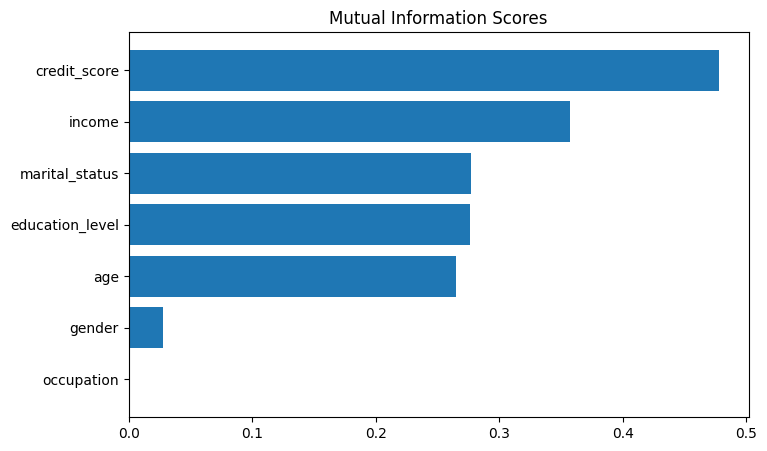

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Here, we can clearly see that `credit_score` exhibits a strong relationship with `loan_status` the target.

# Model Training

First, lets construct a tree using all the features in the loan dataset.

In [10]:
#Encoding the categorical features

df_encoded = pd.get_dummies(loan, columns=[ 'marital_status','gender','education_level','occupation'], dtype = int)
df_encoded

,age,income,credit_score,loan_status,marital_status_Married,marital_status_Single,gender_Female,gender_Male,education_level_Associate's,education_level_Bachelor's,...,occupation_Researcher,occupation_Sales,occupation_Salesman,occupation_Server,occupation_Software,occupation_Student,occupation_Stylist,occupation_Teacher,occupation_Veterinarian,occupation_Writer
0,32,85000,720,Approved,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,45,62000,680,Approved,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,25000,590,Denied,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,51,105000,780,Approved,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,36,75000,710,Approved,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,39,100000,770,Approved,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
57,25,32000,570,Denied,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,43,95000,760,Approved,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
59,30,55000,650,Approved,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

x = df_encoded.drop('loan_status', axis = 1)
y = df_encoded['loan_status']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.1, random_state=42)
 
clf = DecisionTreeClassifier(criterion='gini',max_depth = 5, min_samples_leaf=4 )
clf = clf.fit(X_train, y_train)


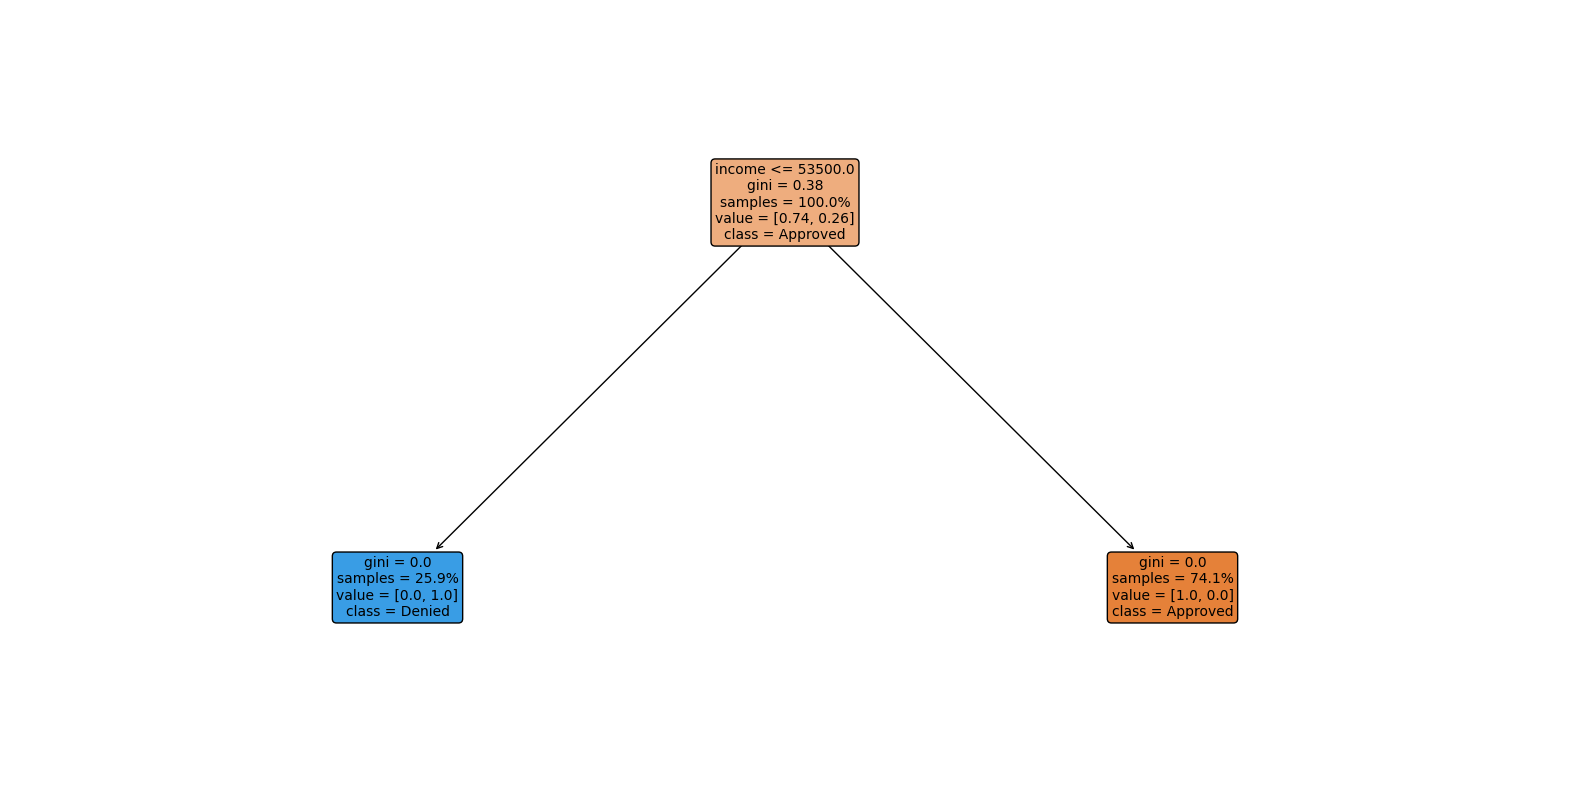

In [12]:
def plot_decision_tree(model, feature_names, class_names):
    tree = plot_tree(model, feature_names = feature_names, class_names = class_names,
                     rounded = True, proportion = True, precision = 2, filled = True, fontsize=10)
    
    return tree

plt.figure(figsize=(20,10))
plot_decision_tree(clf, x.columns, clf.classes_)
plt.show()

Here, `income` is the root-node of the tree and there are 2 leaf-nodes.

In [13]:
X_test = df_encoded.drop('loan_status', axis=1)
y_test = df_encoded.loan_status

In [14]:
df_encoded.columns

Index(['age', 'income', 'credit_score', 'loan_status',
       'marital_status_Married', 'marital_status_Single', 'gender_Female',
       'gender_Male', 'education_level_Associate's',
       'education_level_Bachelor's', 'education_level_Doctoral',
       'education_level_High School', 'education_level_Master's',
       'occupation_Accountant', 'occupation_Analyst', 'occupation_Architect',
       'occupation_Artist', 'occupation_Banker', 'occupation_Chef',
       'occupation_Consultant', 'occupation_Dentist', 'occupation_Designer',
       'occupation_Doctor', 'occupation_Editor', 'occupation_Electrician',
       'occupation_Engineer', 'occupation_HR', 'occupation_IT',
       'occupation_Lawyer', 'occupation_Manager', 'occupation_Marketing',
       'occupation_Musician', 'occupation_Nurse', 'occupation_Pharmacist',
       'occupation_Photographer', 'occupation_Pilot', 'occupation_Professor',
       'occupation_Programmer', 'occupation_Psychologist',
       'occupation_Realtor', 'occupati

In [15]:
y_pred = clf.predict(X_test)

In [16]:
results = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test
})

results

,Predicted,Actual
0,Approved,Approved
1,Approved,Approved
2,Denied,Denied
3,Approved,Approved
4,Approved,Approved
...,...,...
56,Approved,Approved
57,Denied,Denied
58,Approved,Approved
59,Approved,Approved


**Performance Metrics**

In [17]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[45,  0],
       [ 0, 16]])

In [18]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    Approved       1.00      1.00      1.00        45
      Denied       1.00      1.00      1.00        16

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



Now,according to the classification report above,the model turns out to be 100% accurate which seems quite weird. This leads us to the problem of overfitting which is quite common incase of Decision Trees. 

Hence,now we will train our model on fewer features and we will select those features based on the `Feature Engineering` we had performed earlier.

# Training the model with selective features

In [19]:
loan_test = loan.drop(columns =['education_level', 'gender', 'occupation'])
loan_test


,age,marital_status,income,credit_score,loan_status
0,32,Married,85000,720,Approved
1,45,Single,62000,680,Approved
2,28,Single,25000,590,Denied
3,51,Married,105000,780,Approved
4,36,Married,75000,710,Approved
...,...,...,...,...,...
56,39,Married,100000,770,Approved
57,25,Single,32000,570,Denied
58,43,Married,95000,760,Approved
59,30,Single,55000,650,Approved


In [20]:
loan_test_encoded = pd.get_dummies(loan_test, columns=['marital_status'], dtype = int)
loan_test_encoded

,age,income,credit_score,loan_status,marital_status_Married,marital_status_Single
0,32,85000,720,Approved,1,0
1,45,62000,680,Approved,0,1
2,28,25000,590,Denied,0,1
3,51,105000,780,Approved,1,0
4,36,75000,710,Approved,1,0
...,...,...,...,...,...,...
56,39,100000,770,Approved,1,0
57,25,32000,570,Denied,0,1
58,43,95000,760,Approved,1,0
59,30,55000,650,Approved,0,1


In [21]:
a = loan_test_encoded.drop('loan_status', axis = 1)
b = loan_test_encoded['loan_status']

a_train, b_test, b_train, a_test = train_test_split(a, b, test_size=.2, random_state=42)
 
new_clf = DecisionTreeClassifier(criterion='gini',max_depth = 3, min_samples_leaf=4 )
new_clf = new_clf.fit(a_train, b_train)


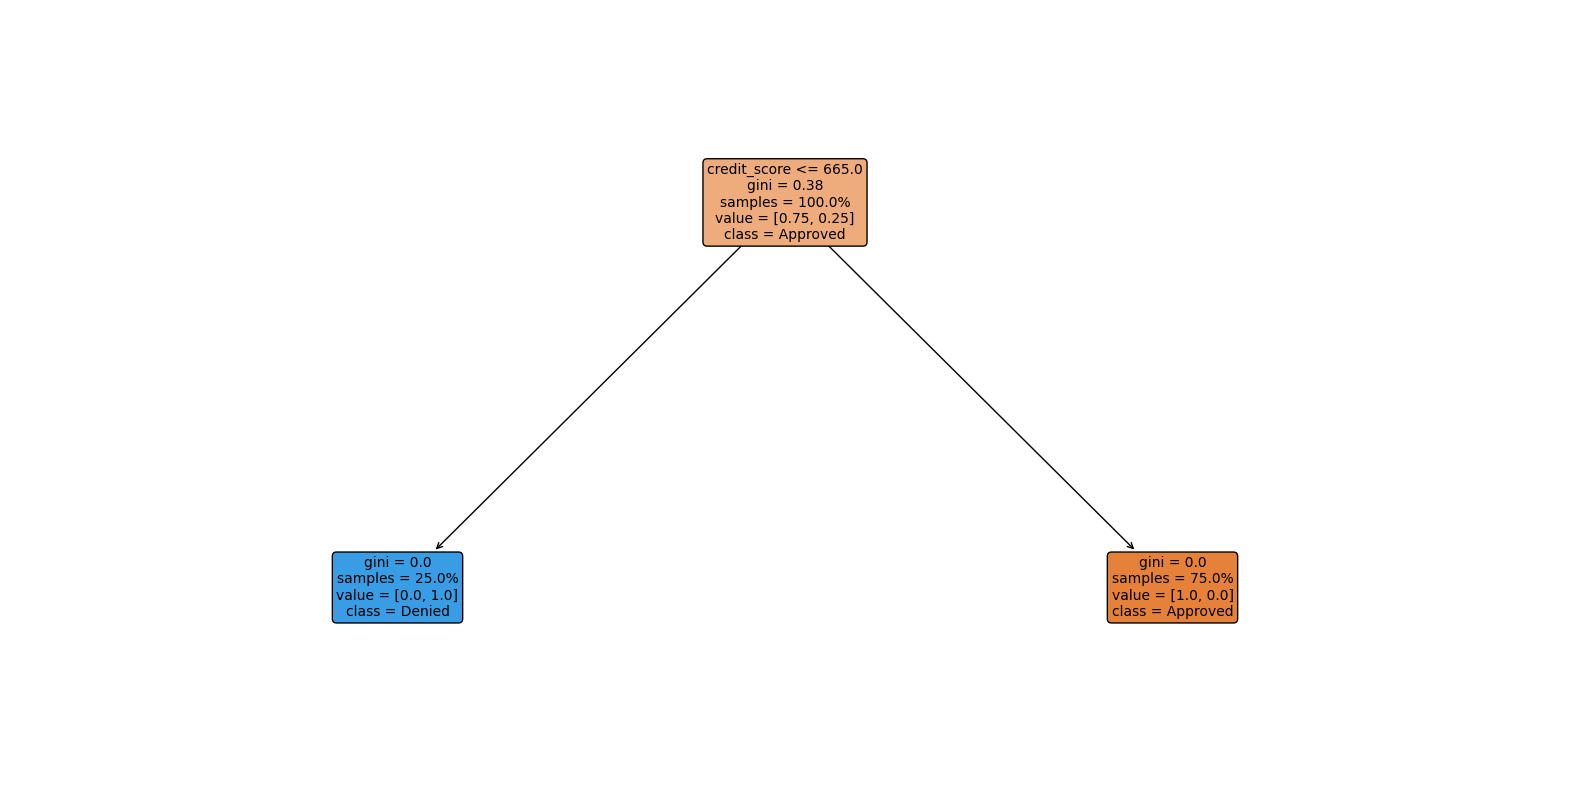

In [22]:
def plot_decision_tree(model, feature_names, class_names):
    tree = plot_tree(model, feature_names = feature_names, class_names = class_names,
                     rounded = True, proportion = True, precision = 2, filled = True, fontsize=10)
    
    return tree

plt.figure(figsize=(20,10))
plot_decision_tree(new_clf, a.columns, new_clf.classes_)
plt.show()

Here, `credit_score` is the root-node of the tree, but when we had trained the model on the entire dataset, the feature `income` was present at the top. This clearly indicates that feature importance has helped us to prevent the problem of `overfitting` to some extent.

In [23]:
a_test = loan_test_encoded.drop('loan_status', axis=1)
b_test = loan_test_encoded.loan_status

In [24]:
b_pred = new_clf.predict(a_test)

In [25]:
new_results = pd.DataFrame({
    'Predicted': b_pred,
    'Actual': b_test
})

new_results

,Predicted,Actual
0,Approved,Approved
1,Approved,Approved
2,Denied,Denied
3,Approved,Approved
4,Approved,Approved
...,...,...
56,Approved,Approved
57,Denied,Denied
58,Approved,Approved
59,Denied,Approved


In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(b_test, b_pred)
conf_matrix

array([[44,  1],
       [ 0, 16]])

In [27]:
from sklearn.metrics import classification_report

report = classification_report(b_test, b_pred)
print(report)

              precision    recall  f1-score   support

    Approved       1.00      0.98      0.99        45
      Denied       0.94      1.00      0.97        16

    accuracy                           0.98        61
   macro avg       0.97      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61



We can see that now the metrics values have changed, and the model is not exactly 100% accurate.
While this might still not be the most accurate analysis of the Decision Tree model but it helps us understand how certain features can affect the results of a model.

**Do share your comments and suggestions, and if this notebook was helpful,don't forget to upvote.** Thank you!